#### To develop a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost in sequence, begin by loading and cleaning your data. Select important features and split the dataset into training and testing sets. Normalize these features through feature scaling. Use a sparse autoencoder to reduce the dimensionality of your data, enhancing manageability and focus. Apply an Isolation Forest to effectively identify initial anomalies, and then refine the detection with XGBoost, a powerful classifier that improves the model's sensitivity and accuracy. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix. This approach combines the strengths of dimensionality reduction, anomaly isolation, and advanced classification to effectively detect anomalies in diverse data scenarios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder

Epoch 1/50
195/195 [==============================] - 0s 1ms/step - loss: 43.3949
Epoch 2/50
195/195 [==============================] - 0s 977us/step - loss: 42.9089
Epoch 3/50
195/195 [==============================] - 0s 962us/step - loss: 42.8851
Epoch 4/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8759
Epoch 5/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8700
Epoch 6/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8651
Epoch 7/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8613
Epoch 8/50
195/195 [==============================] - 0s 985us/step - loss: 42.8580
Epoch 9/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8550
Epoch 10/50
195/195 [==============================] - 0s 973us/step - loss: 42.8528
Epoch 11/50
195/195 [==============================] - 0s 950us/step - loss: 42.8513
Epoch 12/50
195/195 [==============================] - 0s 1ms/step - loss: 42.8501
Epo

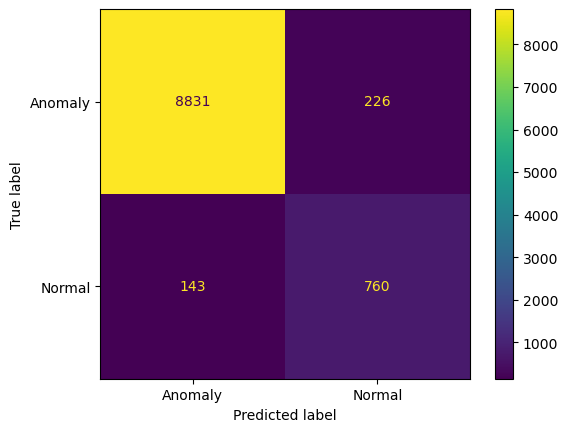

In [3]:

def auto_enco_xgb_iso():
    # Load and preprocess data
    data1 = pd.read_csv('pow_cons.csv')
    
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['Date','Time'], axis=1)
#     data.info()
    
    data.dropna(axis=0, inplace=True)
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    
    X = data.drop('Global_active_power', axis=1)  # Assuming 'Global_active_power' is the target column
    y_cont = data['Global_active_power']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 0.2, 1, 0)  # Define `threshold` based on the dataset

    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=3)
    X_selected = selector.fit_transform(X, y)

    
    # Dimensionality reduction with sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    encoder = Model(input_layer, encoded)
    X_encoded = encoder.predict(X_selected)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use XGBoost to identify normal data points
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train_scaled, y_train)
    xgb_preds = xgb.predict(X_train_scaled)
    
    # Filter only normal data points as identified by XGBoost
    normal_indices = np.where(xgb_preds == 0)[0]  # Assuming '0' is normal
    X_train_normal = X_train_scaled[normal_indices]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict and evaluate the model on the test set using Isolation Forest
    iso_preds = iso_forest.predict(X_test_scaled)
    # Convert predictions to match the original label (1 for normal, -1 for anomaly)
    iso_preds = np.where(iso_preds == 1, 0, 1)  # Assuming '0' is normal, '1' is anomaly
    
    # Evaluate the final outcome from Isolation Forest
    precision = precision_score(y_test, iso_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, iso_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, iso_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')

    print(classification_report(y_test, iso_preds))
    
    # Output the metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, iso_preds, labels=[1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()
    

auto_enco_xgb_iso()
